In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from rotate.k2 import get_light_curve
from rotate.model import RotationModel

In [50]:
epicid = 201613023
t, F, yerr = get_light_curve(epicid)

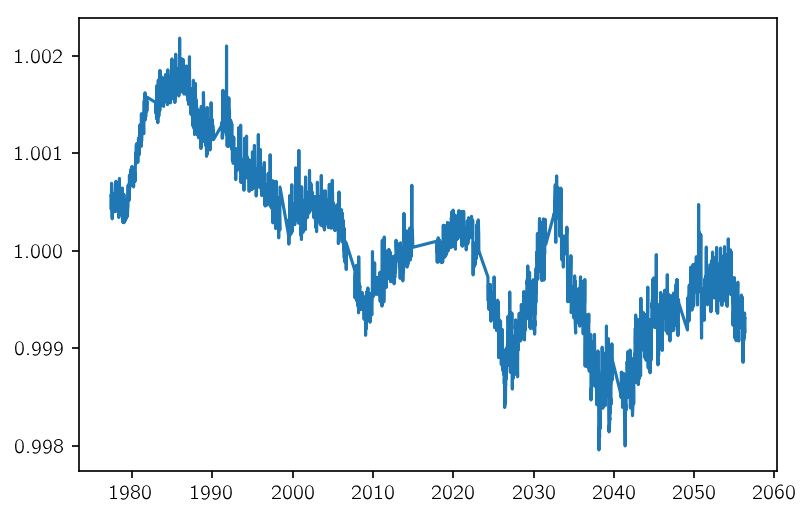

In [51]:
plt.plot(t, np.sum(F, axis=1))

In [52]:
model = RotationModel(t, F, yerr)

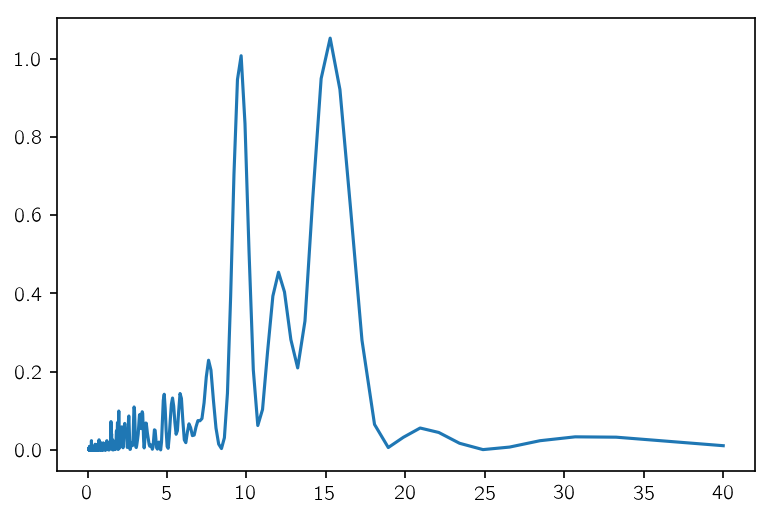

In [53]:
ls = model.lomb_scargle_result["periodogram"]
plt.plot(1./ls[0], ls[1])

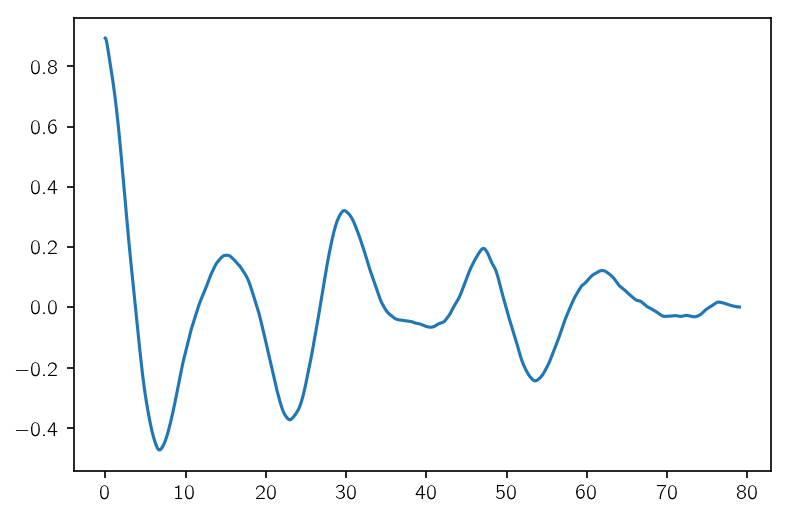

In [54]:
ac = model.autocorr_result["autocorr"]
plt.plot(ac[0], ac[1])

In [55]:
model.autocorr_period, model.lomb_scargle_period

(30.969127892050892, 15.229907161573699)

In [56]:
%timeit model.log_likelihood()

100 loops, best of 3: 10.2 ms per loop


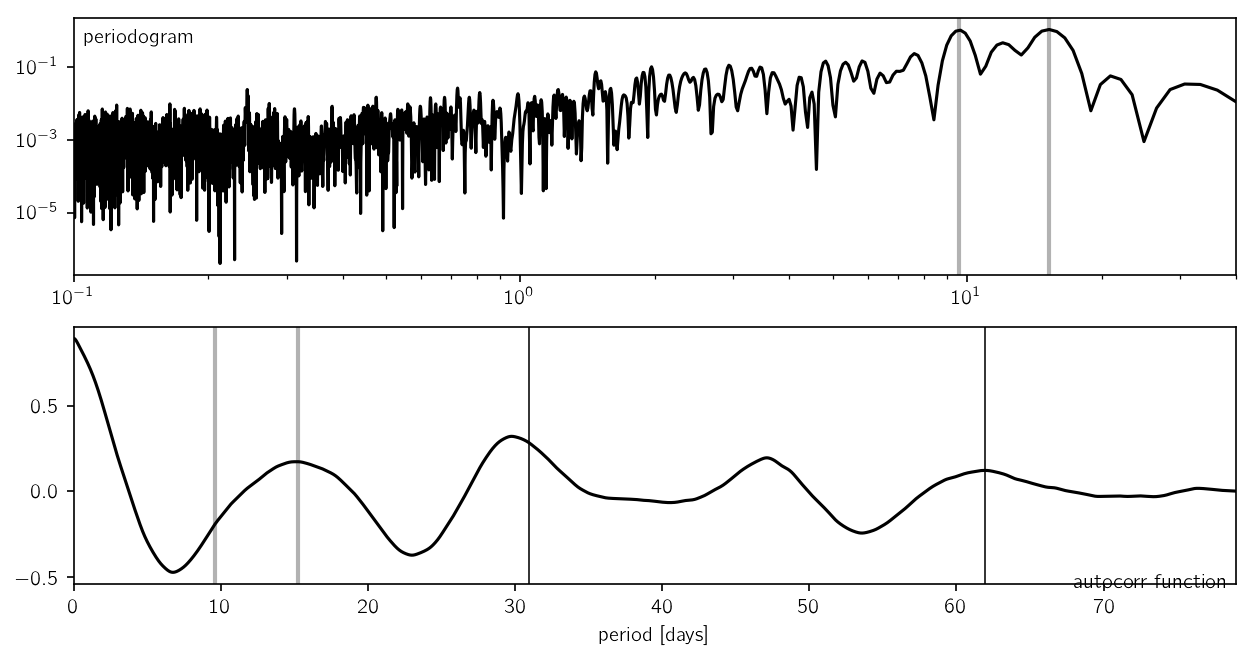

In [79]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))

ax = axes[0]
freq, power = model.lomb_scargle_result["periodogram"]
period = 1.0 / freq
ax.loglog(period, power, "k")
for peak in model.lomb_scargle_result["peaks"]:
    ax.axvline(peak["period"], color="k", alpha=0.3, lw=2)
ax.annotate("periodogram", xy=(0, 1), xycoords="axes fraction",
            ha="left", va="top", xytext=(5, -5), textcoords="offset points")
ax.set_xlim(model.min_period, model.max_period)

ax = axes[1]
tau, acor = model.autocorr_result["autocorr"]
ax.plot(tau, acor, "k")
for peak in model.autocorr_result["peaks"]:
    period = peak["period"]
    t = period
    for peak in model.autocorr_result["peaks"]:
        period = peak["period"]
        t = period
        while t < model.t.max():
            ax.axvline(t, color="k", lw=0.75)
            t += period
    for peak in model.lomb_scargle_result["peaks"]:
        ax.axvline(peak["period"], color="k", alpha=0.3, lw=2)
ax.set_xlim(0, model.t.max() - model.t.min())
ax.annotate("autocorr function", xy=(1, 0), xycoords="axes fraction",
            ha="right", va="top", xytext=(-5, 5), textcoords="offset points")

ax.set_xlabel("period [days]")

In [57]:
model.optimize()

      fun: -26959.849849619273
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.26520866, -1.29221007,  1.75823516, -1.09321263,  2.49783625,
        2.52875907,  2.43235263,  0.07639755])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 504
      nit: 36
   status: 0
  success: True
        x: array([-13.82879512,  -0.29417293,  -9.4895896 ,   1.02939118,
        -5.        ,  -5.        ,  -5.        ,  -0.94438227])

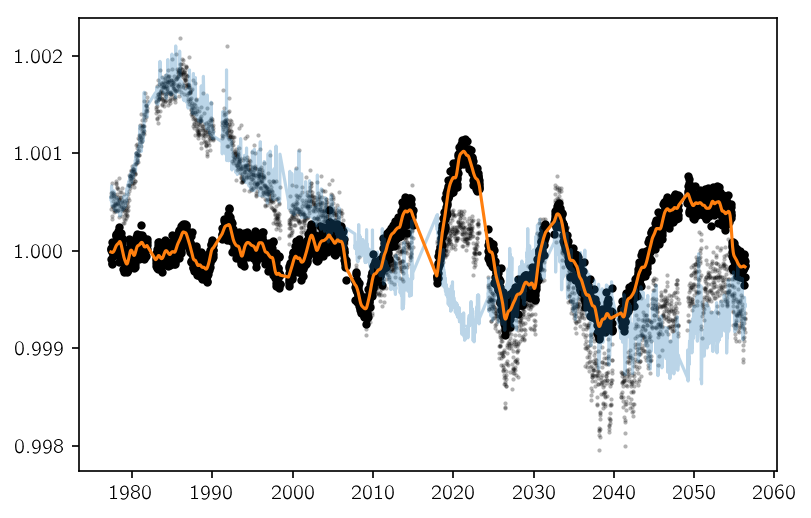

In [58]:
pld_pred, gp_pred = model.get_predictions()

fdet = model.fsap - pld_pred

plt.plot(model.t, model.fsap, ".k", alpha=0.3, ms=4, mec="none")
plt.plot(model.t, fdet, ".k")
plt.plot(model.t, pld_pred + 1.0, alpha=0.3)
plt.plot(model.t, gp_pred)

In [59]:
from multiprocessing import Pool

def fit_for_period(period):
    model.set_default()
    model.period = period
    model.rotation_gp.freeze_parameter("kernel:terms[2]:log_P")
    soln = model.optimize_gp()
    model.rotation_gp.thaw_parameter("kernel:terms[2]:log_P")
    soln = model.optimize_gp()
    return (soln.fun, soln)

model.use_rotation_gp()
periods = [p["period"] for p in model.lomb_scargle_result["peaks"]]
periods += [p["period"] for p in model.autocorr_result["peaks"]]

with Pool() as pool:
    results = list(pool.map(fit_for_period, periods))

sr = sorted(results, key=lambda o: o[0])
model.gp.set_parameter_vector(sr[0][-1].x)

In [60]:
model.optimize()

      fun: -26983.875631943072
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.40272425, -5.70435077, -1.50503183,  0.63046173,  0.09058567,
        0.22700988, -2.96313374,  0.24156179, -0.10149961, -0.12769306,
        0.02692104,  2.52584869,  2.5069312 ,  2.46000127,  0.09749783])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 928
      nit: 32
   status: 0
  success: True
        x: array([-17.87667751,   1.14472989,  -9.50554921, -14.97630338,
         2.6289827 ,   2.0998708 ,   2.21991232,  -3.38592505,
        -2.00250075,  -2.46845575,   1.13271863,  -5.        ,
        -5.        ,  -5.        ,  -0.95990533])

In [61]:
model.rotation_gp.get_parameter_names()

('kernel:terms[0]:log_S0',
 'kernel:terms[0]:log_omega0',
 'kernel:terms[1]:log_sigma',
 'kernel:terms[2]:log_a1',
 'kernel:terms[2]:log_b1',
 'kernel:terms[2]:log_f1',
 'kernel:terms[2]:log_P',
 'kernel:terms[2]:mix_par',
 'kernel:terms[2]:log_b2',
 'kernel:terms[2]:log_f2')

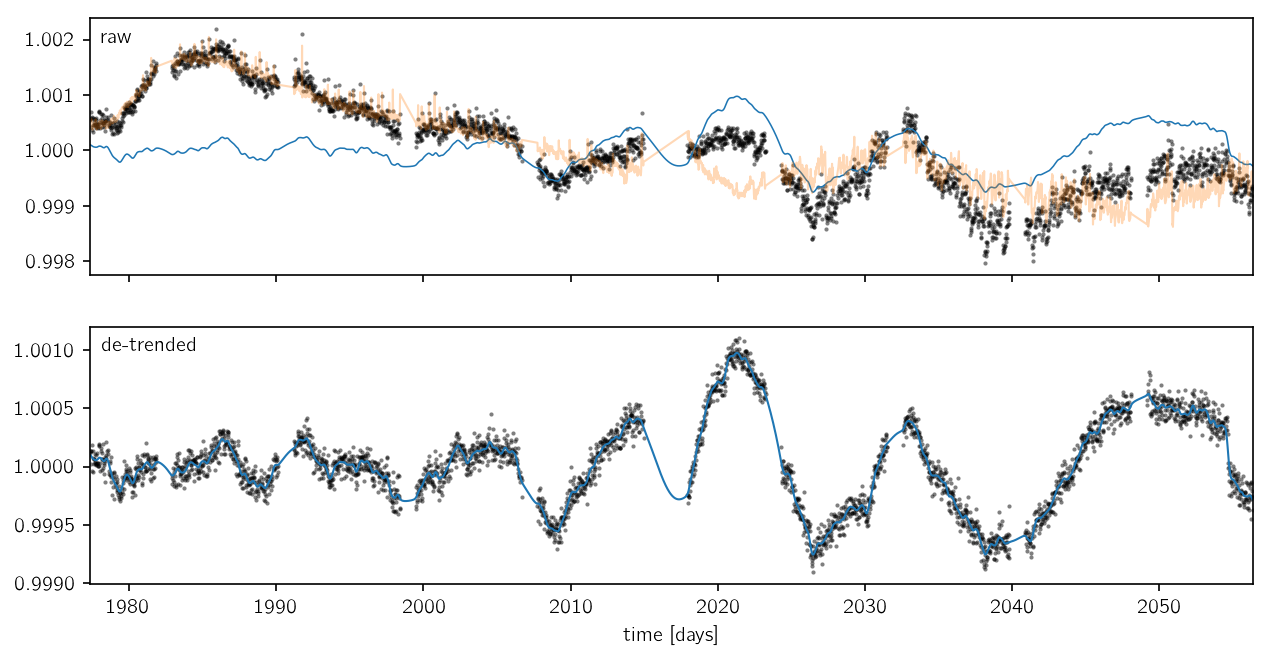

In [62]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

xx = np.linspace(model.t.min(), model.t.max(), len(model.t))
gp_pred = model.gp.predict(model.fdet, xx, return_cov=False)

ax = axes[0]
ax.plot(model.t, model.fsap, ".k", alpha=0.5, ms=4, mec="none")
ax.plot(xx, gp_pred, lw=0.75)
ax.plot(model.t, model.get_pld_model() + 1.0, alpha=0.3, lw=1)
ax.annotate("raw", xy=(0, 1), xycoords="axes fraction",
            ha="left", va="top", xytext=(5, -5), textcoords="offset points")

ax = axes[1]
ax.plot(model.t, model.fdet, ".k", alpha=0.5, ms=4, mec="none")
ax.plot(xx, gp_pred, lw=1)
ax.set_xlim(model.t.min(), model.t.max())
ax.annotate("de-trended", xy=(0, 1), xycoords="axes fraction",
            ha="left", va="top", xytext=(5, -5), textcoords="offset points")

ax.set_xlabel("time [days]")

In [16]:
pld_pred, gp_pred = model.get_predictions()

fdet = model.fsap - pld_pred

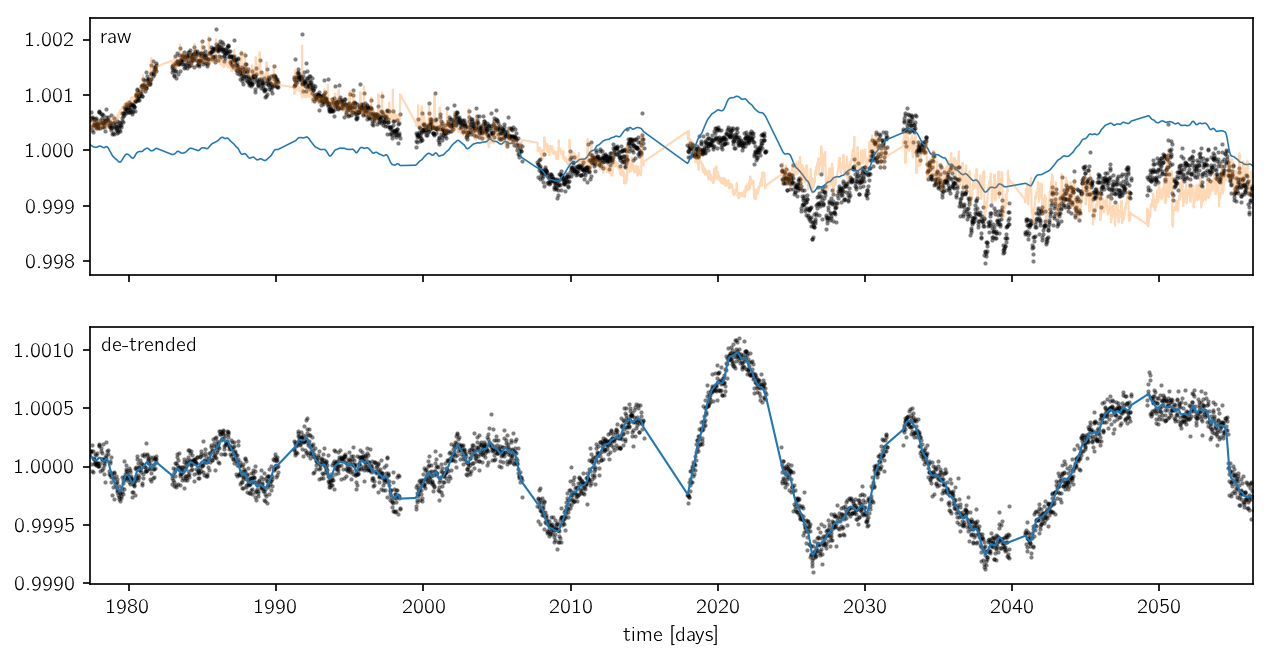

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

ax = axes[0]
ax.plot(model.t, model.fsap, ".k", alpha=0.5, ms=4, mec="none")
ax.plot(model.t, gp_pred, lw=0.75)
ax.plot(model.t, pld_pred + 1.0, alpha=0.3, lw=1)
ax.annotate("raw", xy=(0, 1), xycoords="axes fraction",
            ha="left", va="top", xytext=(5, -5), textcoords="offset points")

ax = axes[1]
ax.plot(model.t, fdet, ".k", alpha=0.5, ms=4, mec="none")
ax.plot(model.t, gp_pred, lw=1)
ax.set_xlim(model.t.min(), model.t.max())
ax.annotate("de-trended", xy=(0, 1), xycoords="axes fraction",
            ha="left", va="top", xytext=(5, -5), textcoords="offset points")

ax.set_xlabel("time [days]")

In [18]:
model.period

9.2065235817729008

In [19]:
def log_prob(params):
    model.gp.set_parameter_vector(params)
    lp = model.gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf, lp, model.period
    ll = model.gp.log_likelihood(model.fdet, quiet=True)
    if not np.isfinite(ll):
        return -np.inf, lp, model.period
    return ll + lp, lp, model.period


mix_ind = model.gp.get_parameter_names().index("kernel:terms[2]:mix_par")
def grad_log_prob(params):
    model.gp.set_parameter_vector(params)
    lp = model.gp.log_prior()
    if not np.isfinite(lp):
        return np.zeros_like(params)
    ll, grad = model.gp.grad_log_likelihood(model.fdet, quiet=True)
    if not np.isfinite(ll):
        return np.zeros_like(params)
    
    theta = np.exp(-params[mix_ind])
    grad[mix_ind] += (theta - 1) / (1 + theta)
    
    return grad

In [20]:
model.set_default()
best_params = model.gp.get_parameter_vector()
grad = grad_log_prob(best_params)
eps = 1e-5
for i in range(len(best_params)):
    best_params[i] += eps
    plus = log_prob(best_params)[0]
    best_params[i] -= 2*eps
    minus = log_prob(best_params)[0]
    g = 0.5 * (plus - minus) / eps
    best_params[i] += eps
    print(g, grad[i], g - grad[i])

4.71362582175 4.71363063675 -4.81499760951e-06
23.0593766901 23.0593796072 -2.91712708744e-06
-971.07929796 -971.079296653 -1.30712601276e-06
-9.16221997613 -9.16221580215 -4.17398038266e-06
0.841049950395 0.841047529663 2.42073187617e-06
-1.08992517198 -1.08991453973 -1.0632252593e-05
25.7632664216 25.763264883 1.53852242235e-06
-2.71268036158 -2.71268550999 5.14841108323e-06
1.28938791022 1.28938754744 3.6278186144e-07
-0.28763734008 -0.287637878441 5.38361504709e-07


In [22]:
%timeit grad_log_prob(best_params)

10 loops, best of 3: 98.5 ms per loop


In [35]:
import emcee

moves = [
#     emcee.moves.HamiltonianMove([5, 10], [1e-5, 0.1]),
    emcee.moves.StretchMove(randomize_split=True),
    emcee.moves.DEMove(1.0, randomize_split=True),
    emcee.moves.DESnookerMove(randomize_split=True),
]

with Pool() as pool:
    best_params = model.gp.get_parameter_vector()
    init = best_params + 1e-5*np.random.randn(64, len(best_params))
    nwalkers, ndim = init.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool, moves=moves, grad_log_prob_fn=grad_log_prob)
    sampler.run_mcmc(init, 2000, progress=True);

100%|██████████| 2000/2000 [00:40<00:00, 50.51it/s]


In [27]:
with Pool() as pool:
    sampler.pool = pool
    sampler.run_mcmc(None, 10, progress=True)

 20%|██        | 2/10 [00:36<02:05, 15.69s/it]/Users/dforeman/research/projects/rotate/rotate/model.py:163: RuntimeWarning: overflow encountered in exp
  return np.exp(self.rotation_gp.kernel.get_parameter("terms[2]:log_P"))
/Users/dforeman/research/projects/rotate/rotate/model.py:163: RuntimeWarning: overflow encountered in exp
  return np.exp(self.rotation_gp.kernel.get_parameter("terms[2]:log_P"))
/Users/dforeman/research/projects/rotate/rotate/model.py:163: RuntimeWarning: overflow encountered in exp
  return np.exp(self.rotation_gp.kernel.get_parameter("terms[2]:log_P"))
/Users/dforeman/research/projects/rotate/rotate/model.py:163: RuntimeWarning: overflow encountered in exp
  return np.exp(self.rotation_gp.kernel.get_parameter("terms[2]:log_P"))
100%|██████████| 10/10 [02:45<00:00, 17.42s/it]


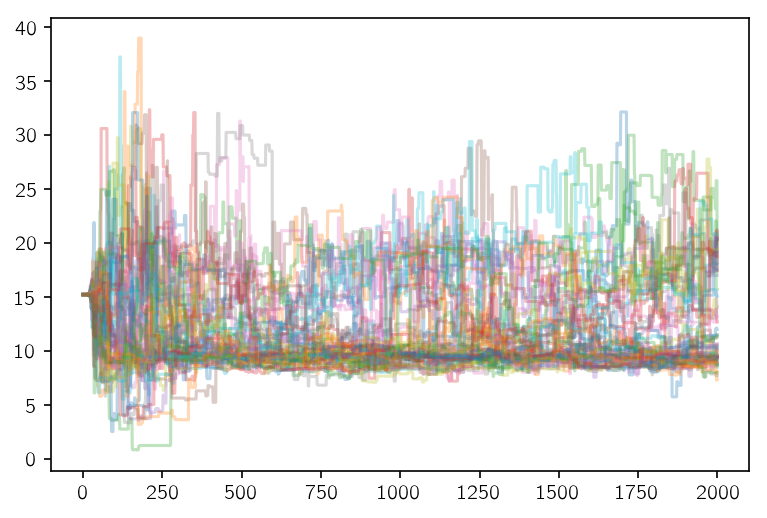

In [36]:
periods = sampler.get_blobs()[:, :, 1]
plt.plot(periods, alpha=0.3);

In [37]:
sampler.get_autocorr_time(discard=1500, quiet=True)

array([ 49.05825599,  51.72861602,  46.00482035,  48.32397106,
        49.26553317,  48.99475142,  45.14064651,  47.47036176,
        45.48670547,  46.54693022])

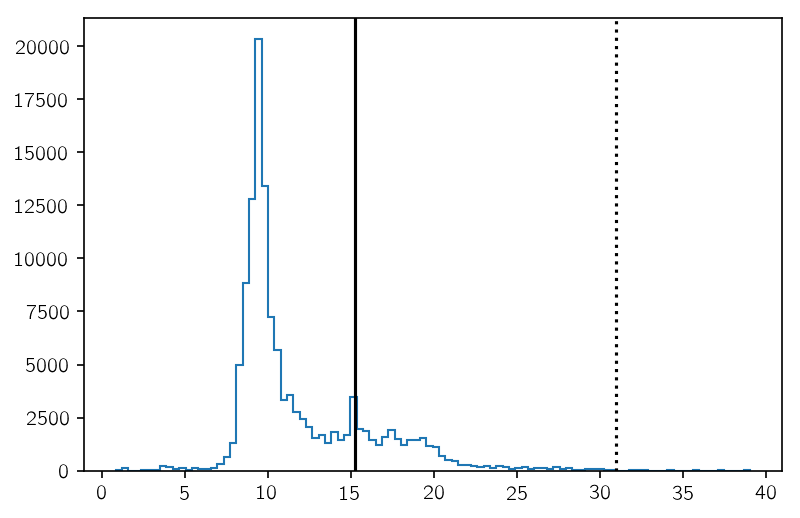

In [38]:
plt.hist((sampler.get_blobs(flat=True)[:, 1]), 100, histtype="step");
plt.axvline((model.lomb_scargle_period), color="k");
plt.axvline((model.autocorr_period), color="k", linestyle="dotted");

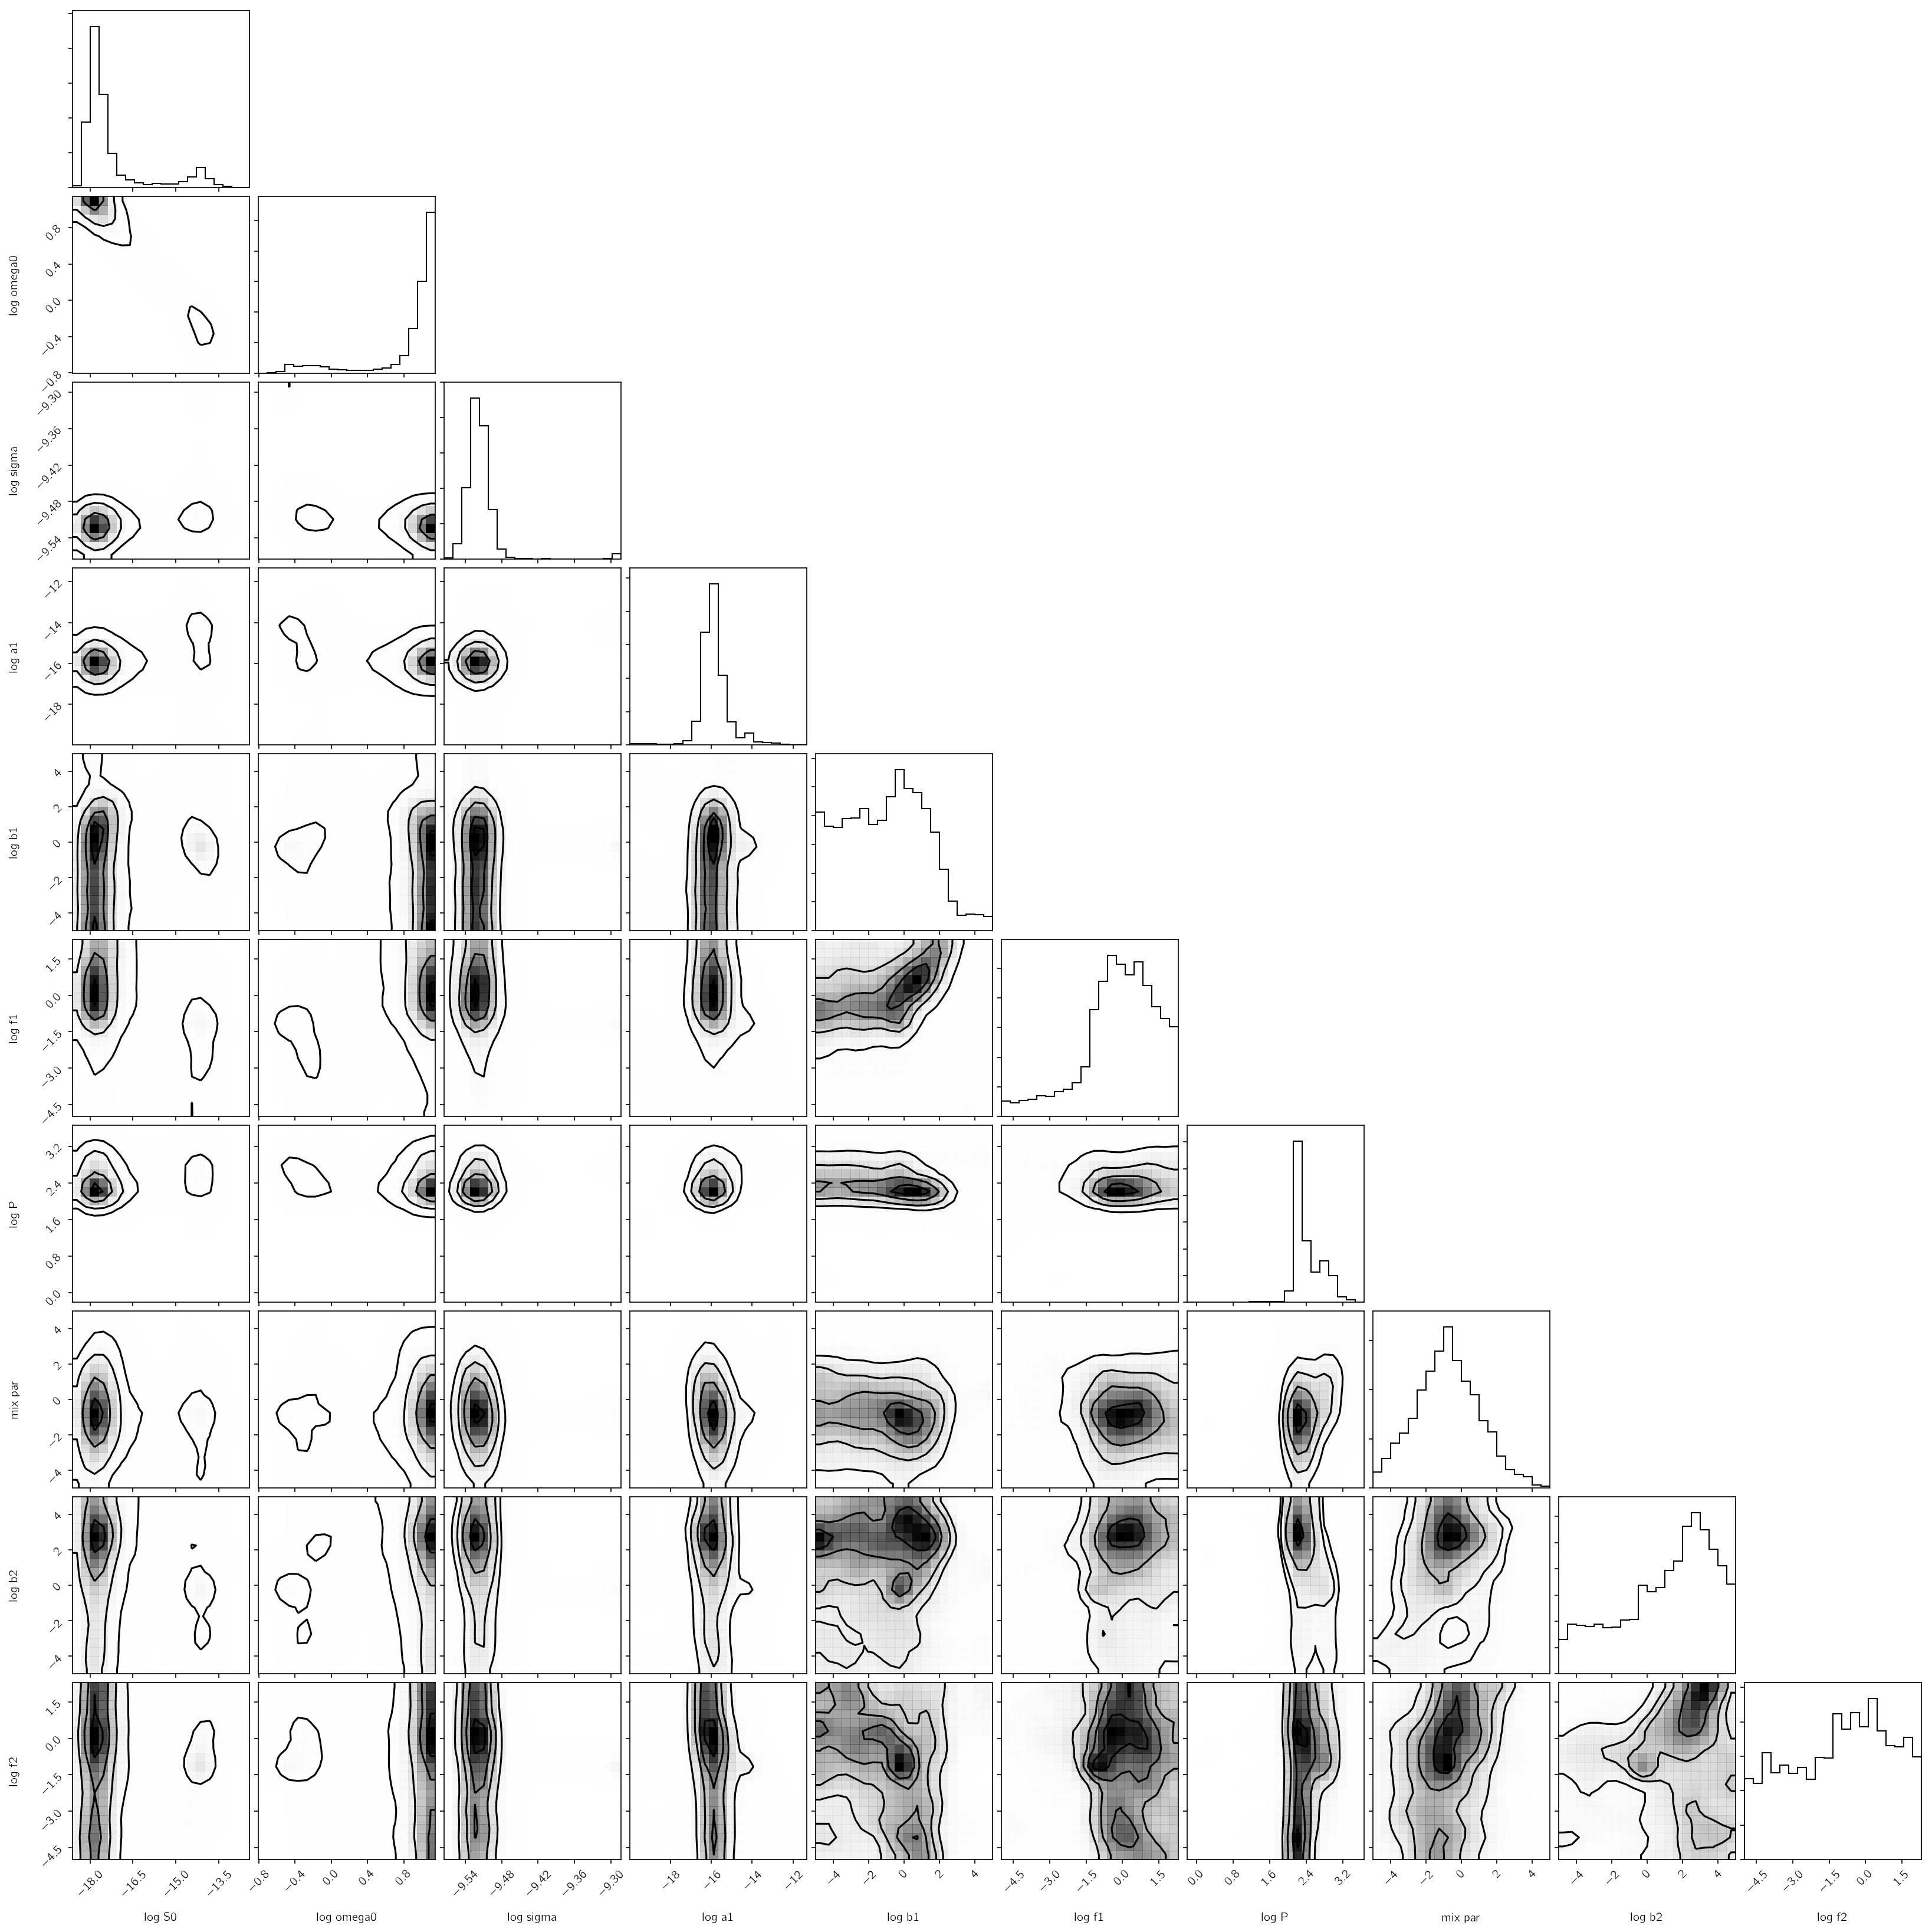

In [39]:
import corner

samples = sampler.get_chain(flat=True)
names = [n.replace("_", " ")[len("kernel:terms[0]:"):] for n in model.gp.get_parameter_names()]
corner.corner(samples, plot_datapoints=False, smooth=1, labels=names);

In [45]:
samps = sampler.get_chain(discard=500, flat=True)
cov = np.cov(samps, rowvar=0)


moves = [
    emcee.moves.HamiltonianMove([5, 100], [1e-5, 1.0], cov=cov),
]

# with Pool() as pool:
#     best_params = model.gp.get_parameter_vector()
#     init = best_params + 1e-5*np.random.randn(64, len(best_params))

init = samps[np.random.randint(len(samps), size=32)]
nwalkers, ndim = init.shape
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_prob, moves=moves, grad_log_prob_fn=grad_log_prob)
sampler2.run_mcmc(init, 5, progress=True);

100%|██████████| 5/5 [01:53<00:00, 16.00s/it]


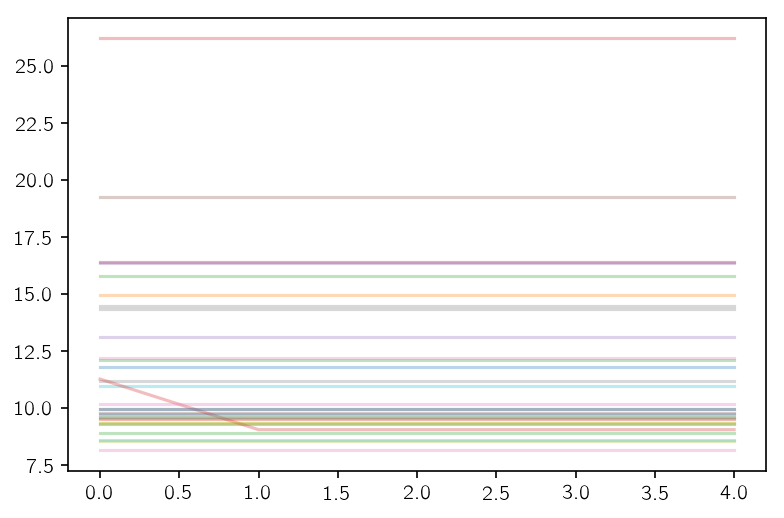

In [46]:
periods = sampler2.get_blobs()[:, :, 1]
plt.plot(periods, alpha=0.3);

In [48]:
sampler2.acceptance_fraction

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])